# Lab 7: Recurrent Neural Networks

### GSB 545: Advanced Machine Learning for Business Analytics

### Name: Joseph Willemsz

### Date: May 23, 2022

#### <u>Predicting Daily Bitcoin Stock</u>

In this lab we will use data prepared using the Alpha Vantage API posted on kaggle.

Dataset: https://www.kaggle.com/datasets/ahmedadam415/digital-currency-time-series

**Goal:** Predict daily bitcoin stock

# Table of Contents

- [Data Import](#1)
- [Simple Recurrent Neural Networks](#2)
- [Long Short-Term Memory Neural Networks](#3)
- [Conclusion](#4)

---

# Data Import <a class="anchor" id="1"></a>

First we import the necessary Python libraries and modules needed in this lab.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

Then we import the bitcoin data as a dataframe `df`. We reverse the order of the observations in the data to make the earlier dates first.

In [3]:
df = pd.read_csv("Data/bitcoin.csv").iloc[::-1]
df

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
999,2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787
998,2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533
997,2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
996,2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
995,2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227
...,...,...,...,...,...,...,...,...,...,...
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827


In the plot below, we can see the daily Bitcoin opening price in USD starting on May 7, 2018 up until January 30, 2021.

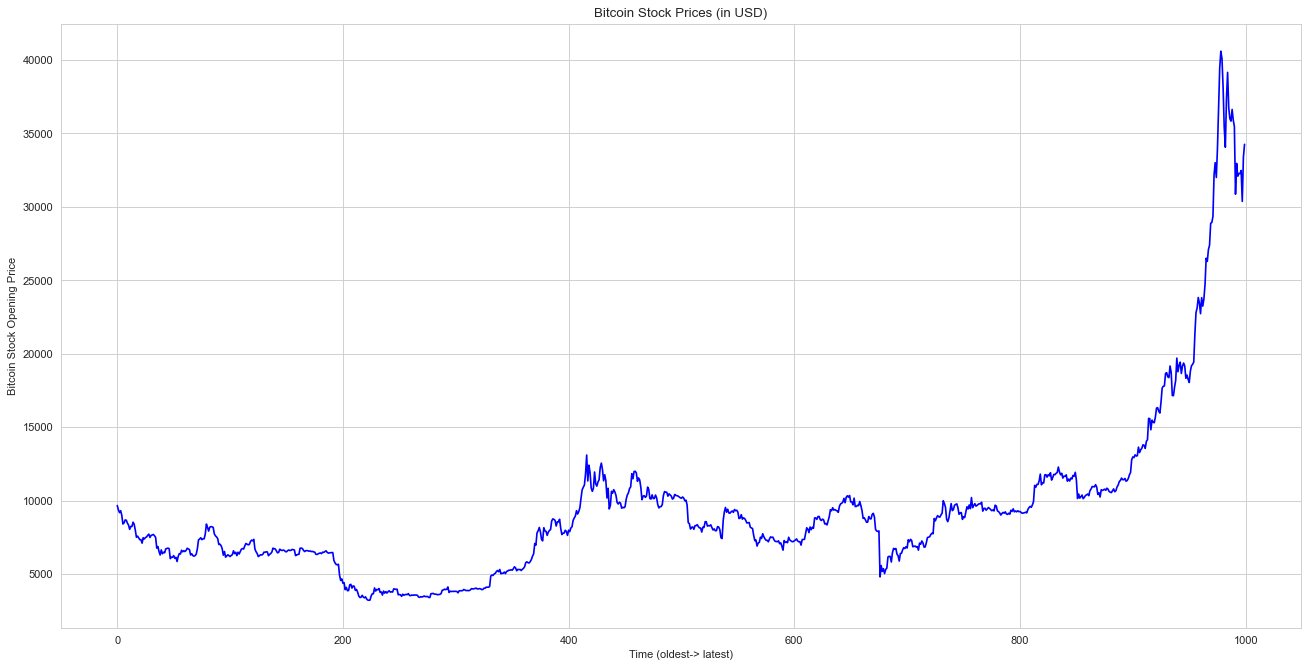

In [4]:
plt.figure(figsize=(20, 10), dpi=80)
sns.set_style("whitegrid")
plt.plot(range(0, len(df.iloc[:, 0])), df.iloc[:, 2], color="blue")
plt.xlabel("Time (oldest-> latest)")
plt.ylabel("Bitcoin Stock Opening Price")
plt.title("Bitcoin Stock Prices (in USD)")
plt.show()

# Simple Recurrent Neural Networks <a class="anchor" id="2"></a>

The cell below contains functions needed to create and assess our Simple Recurrent Neural Networks models.

In [5]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(address, split_percent=0.8):
    df = pd.read_csv(address).drop(['Unnamed: 0'], axis=1)
    df = df.reindex(columns=['open_USD', 'open_SAR', 'high_SAR', 
                             'high_USD', 'low_SAR', 'low_USD', 
                             'close_SAR', 'close_USD', 'volume'])
    df = pd.get_dummies(df).iloc[::-1]
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    sns.set_style("whitegrid")
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('BTC Open Price USD Scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

Time steps: 10
Training proportion: 0.7
Train RMSE: 0.023 RMSE
Test RMSE: 0.193 RMSE
----------------------------------------
Time steps: 10
Training proportion: 0.8
Train RMSE: 0.032 RMSE
Test RMSE: 0.300 RMSE
----------------------------------------
Time steps: 10
Training proportion: 0.9
Train RMSE: 0.023 RMSE
Test RMSE: 0.227 RMSE
----------------------------------------
Time steps: 20
Training proportion: 0.7
Train RMSE: 0.027 RMSE
Test RMSE: 0.143 RMSE
----------------------------------------
Time steps: 20
Training proportion: 0.8
Train RMSE: 0.030 RMSE
Test RMSE: 0.153 RMSE
----------------------------------------
Time steps: 20
Training proportion: 0.9
Train RMSE: 0.030 RMSE
Test RMSE: 0.340 RMSE
----------------------------------------
Time steps: 30
Training proportion: 0.7
Train RMSE: 0.014 RMSE
Test RMSE: 0.164 RMSE
----------------------------------------
Time steps: 30
Training proportion: 0.8
Train RMSE: 0.005 RMSE
Test RMSE: 0.135 RMSE
---------------------------------

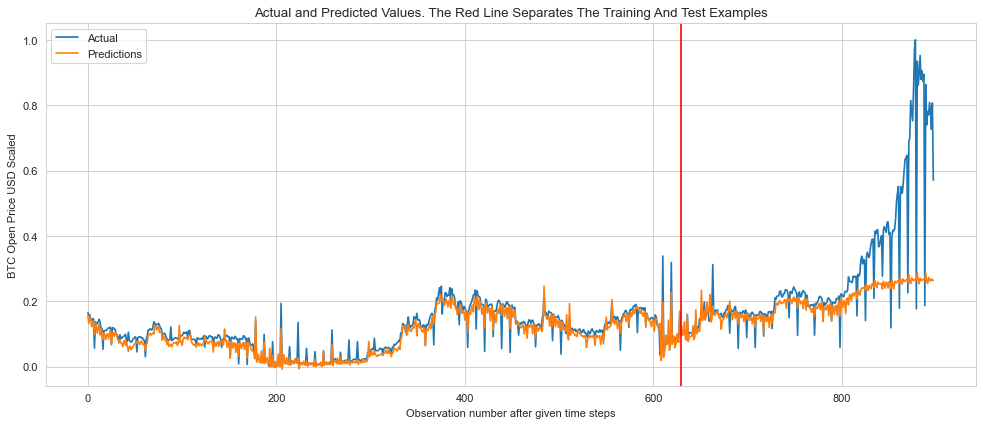

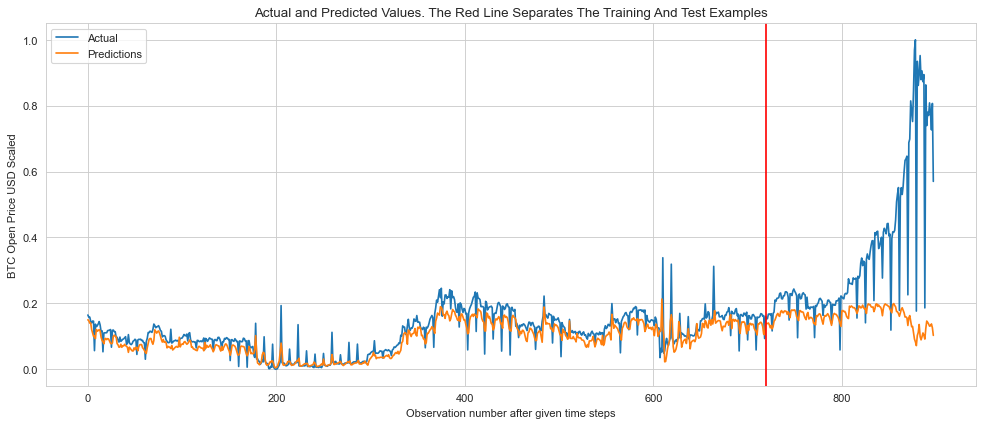

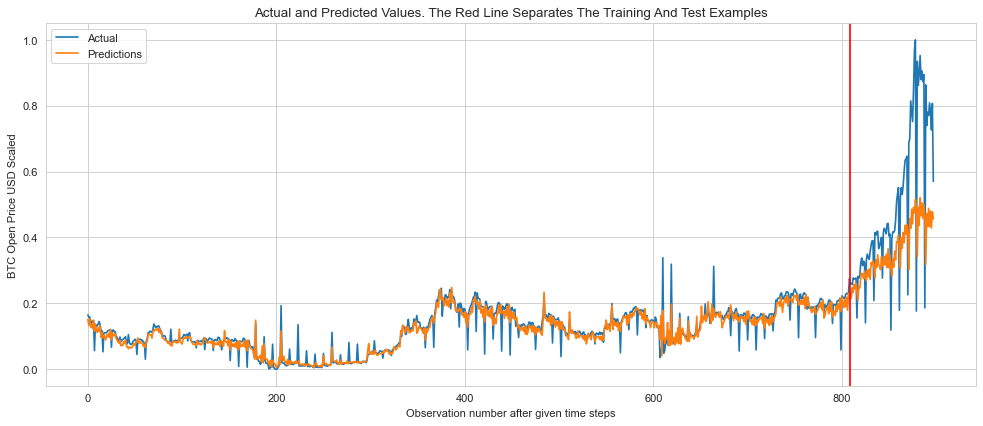

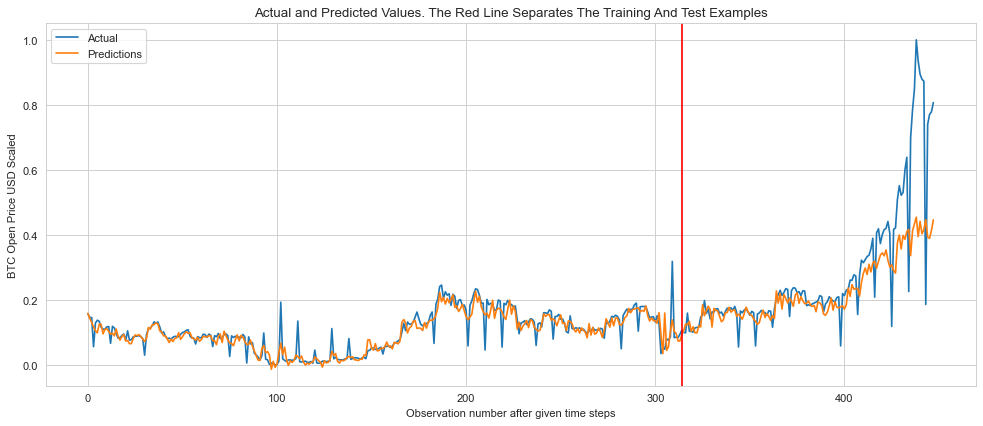

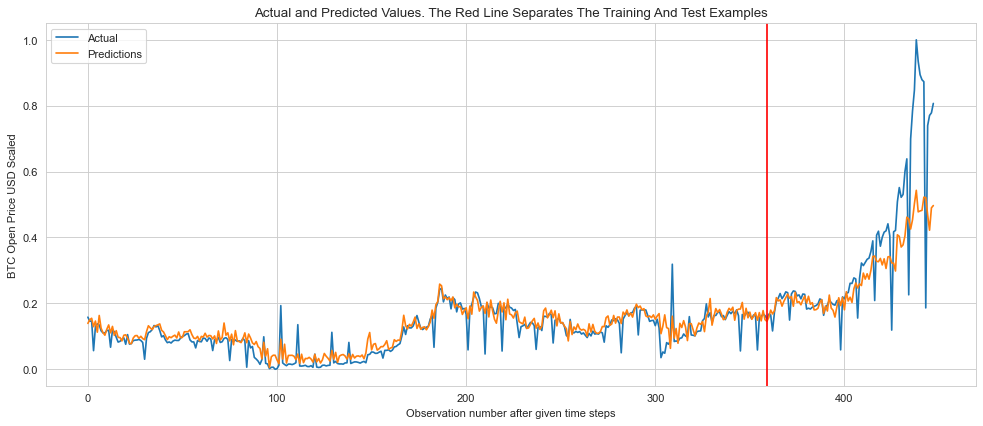

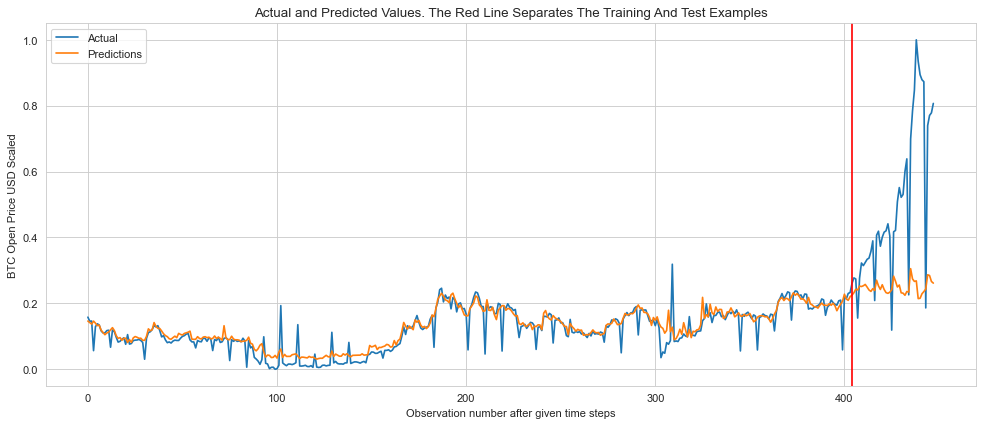

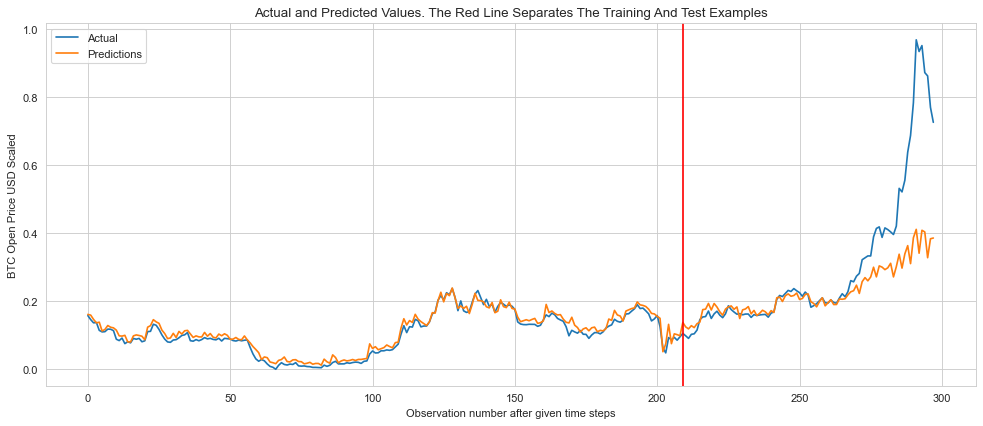

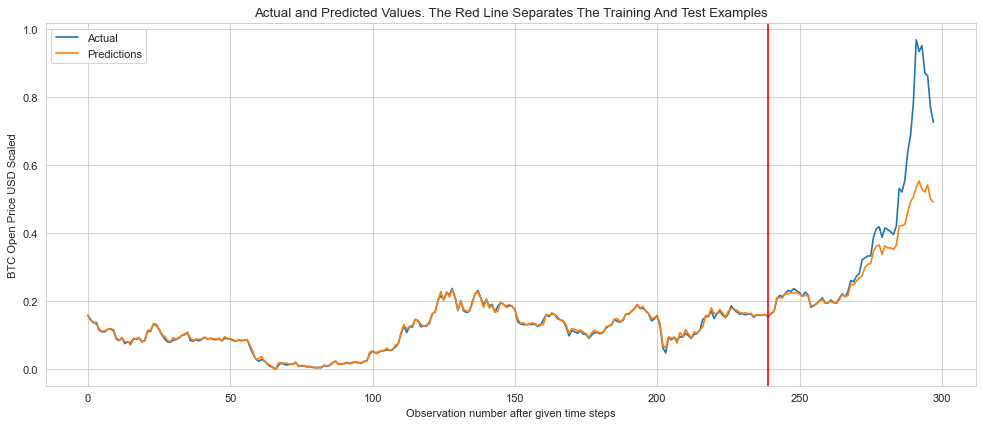

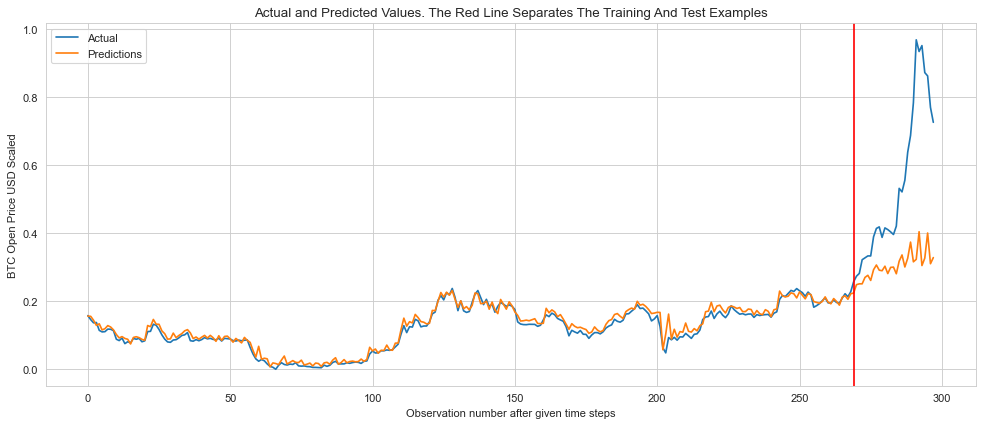

In [6]:
tf.random.set_seed(0)
address = "Data/bitcoin.csv"

for i in [10, 20, 30]:
    for j in [0.7, 0.8, 0.9]:
        time_steps = i
        train_data, test_data, data = get_train_test(address, split_percent = j)
        trainX, trainY = get_XY(train_data, time_steps)
        testX, testY = get_XY(test_data, time_steps)

        # Create model and train
        model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                           activation=['tanh', 'tanh'])        
        model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)

        # make predictions
        train_predict = model.predict(trainX)
        test_predict = model.predict(testX)

        # Print error
        print('Time steps:', i)
        print('Training proportion:', j)
        print_error(trainY, testY, train_predict, test_predict)
        print('----------------------------------------')

        #Plot result
        plot_result(trainY, testY, train_predict, test_predict)

From the results above, we see that the Simple RNN model with the lowest test RMSE (0.135) has the following parameters:
- `time_steps` = 30
- `split percent` = 0.80

# Long Short-Term Memory Neural Networks <a class="anchor" id="3"></a>

The cell below contains functions needed to create and assess our Long Short-Term Memory Neural Networks models.

In [7]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(address, split_percent=0.8):
    df = pd.read_csv(address).drop(['Unnamed: 0'], axis=1)
    df = df.reindex(columns=['open_USD', 'open_SAR', 'high_SAR', 
                             'high_USD', 'low_SAR', 'low_USD', 
                             'close_SAR', 'close_USD', 'volume'])
    df = pd.get_dummies(df).iloc[::-1]
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(layers.LSTM(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    sns.set_style("whitegrid")
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('BTC Open Price USD Scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

Time steps: 10
Training proportion: 0.7
Train RMSE: 0.027 RMSE
Test RMSE: 0.193 RMSE
----------------------------------------
Time steps: 10
Training proportion: 0.8
Train RMSE: 0.026 RMSE
Test RMSE: 0.221 RMSE
----------------------------------------
Time steps: 10
Training proportion: 0.9
Train RMSE: 0.026 RMSE
Test RMSE: 0.313 RMSE
----------------------------------------
Time steps: 20
Training proportion: 0.7
Train RMSE: 0.028 RMSE
Test RMSE: 0.141 RMSE
----------------------------------------
Time steps: 20
Training proportion: 0.8
Train RMSE: 0.032 RMSE
Test RMSE: 0.212 RMSE
----------------------------------------
Time steps: 20
Training proportion: 0.9
Train RMSE: 0.029 RMSE
Test RMSE: 0.256 RMSE
----------------------------------------
Time steps: 30
Training proportion: 0.7
Train RMSE: 0.009 RMSE
Test RMSE: 0.175 RMSE
----------------------------------------
Time steps: 30
Training proportion: 0.8
Train RMSE: 0.014 RMSE
Test RMSE: 0.171 RMSE
---------------------------------

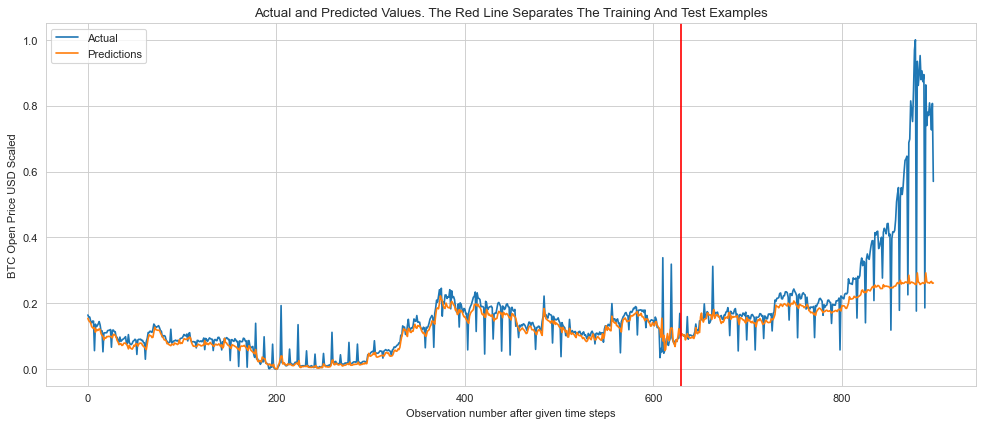

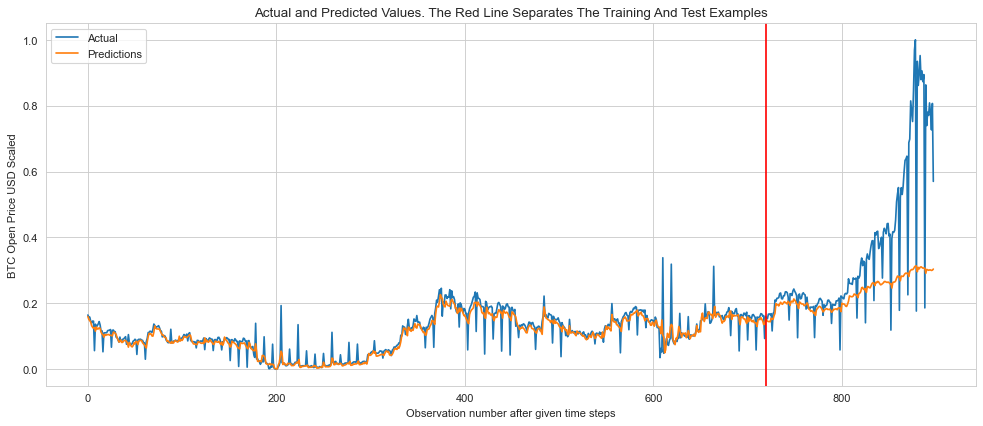

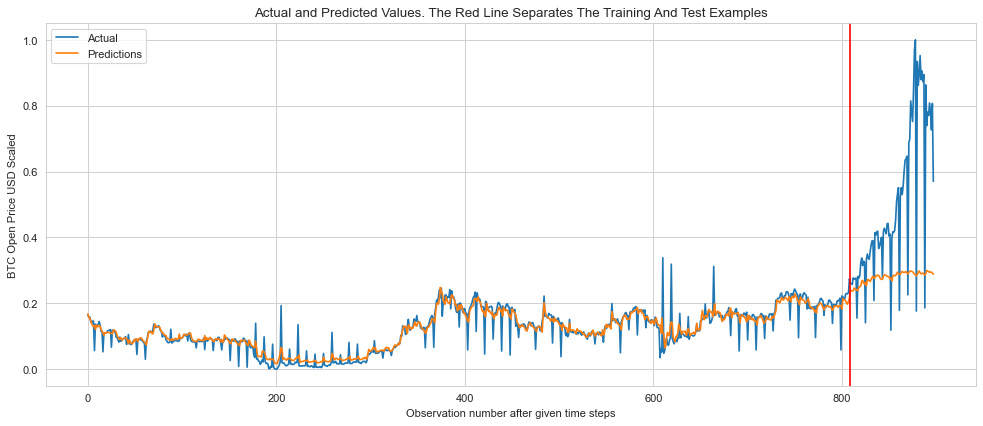

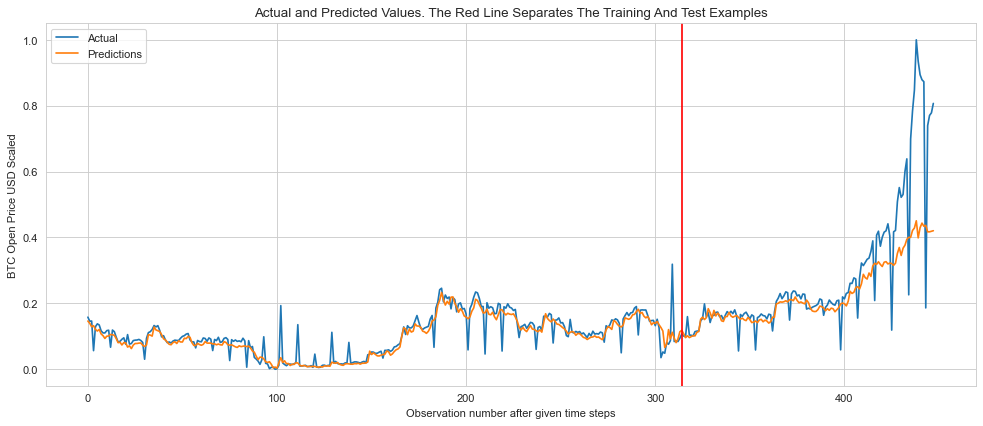

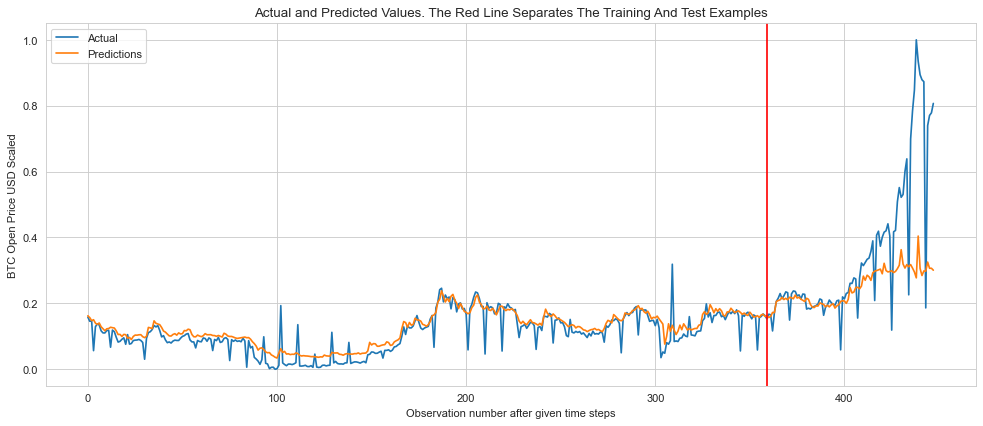

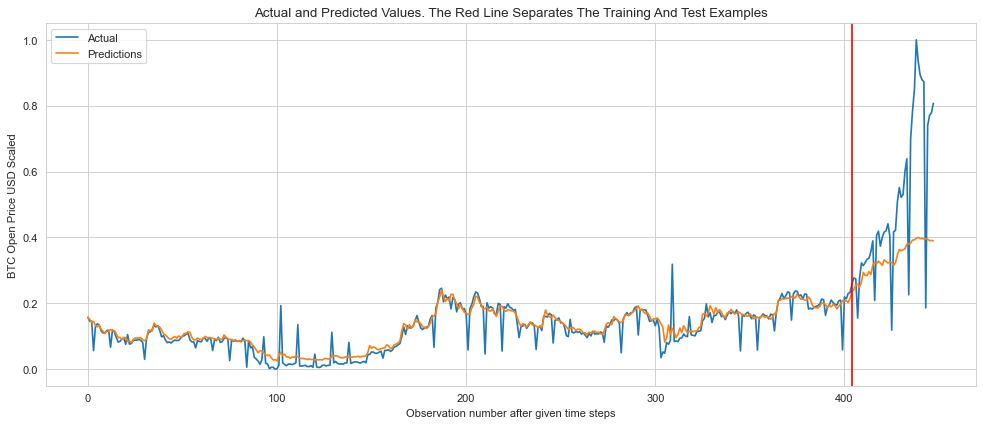

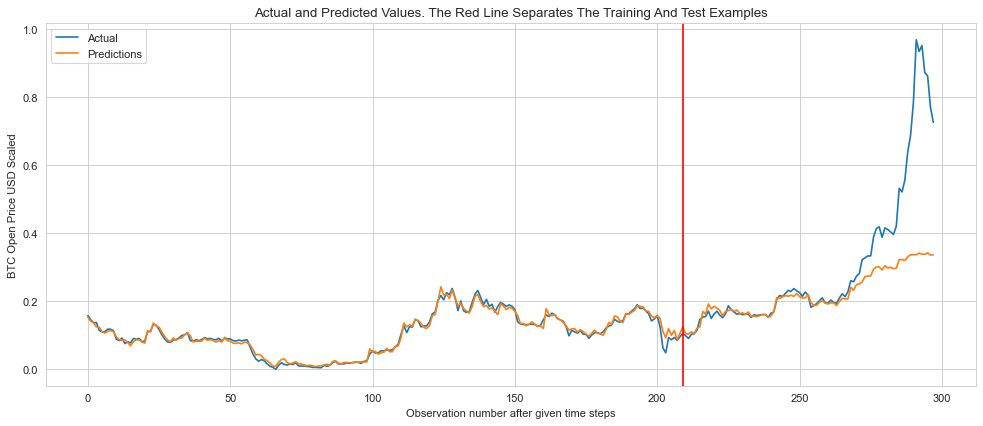

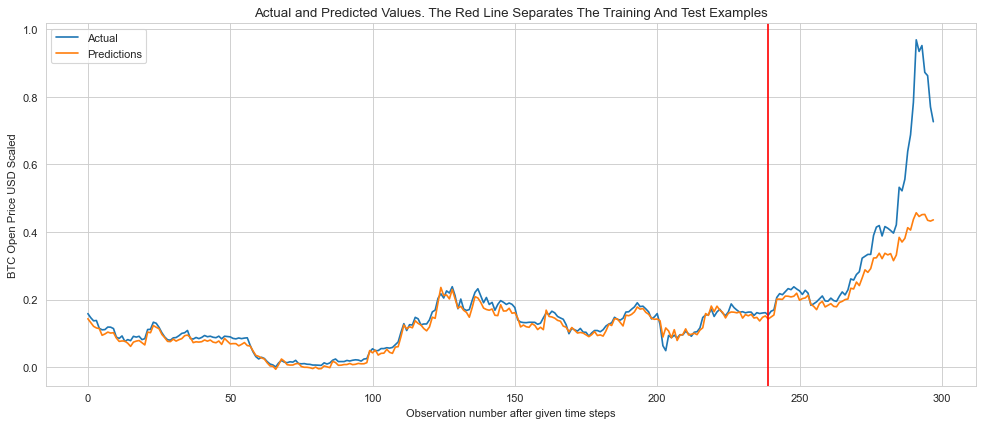

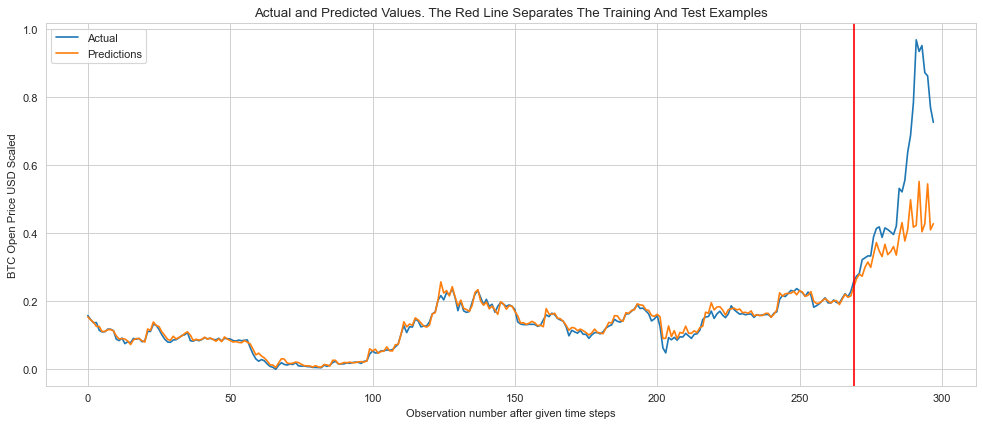

In [8]:
tf.random.set_seed(0)
address = "Data/bitcoin.csv"

for i in [10, 20, 30]:
    for j in [0.7, 0.8, 0.9]:
        time_steps = i
        train_data, test_data, data = get_train_test(address, split_percent = j)
        trainX, trainY = get_XY(train_data, time_steps)
        testX, testY = get_XY(test_data, time_steps)

        # Create model and train
        model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                           activation=['tanh', 'tanh'])
        model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0)

        # make predictions
        train_predict = model.predict(trainX)
        test_predict = model.predict(testX)

        # Print error
        print('Time steps:', i)
        print('Training proportion:', j)
        print_error(trainY, testY, train_predict, test_predict)
        print('----------------------------------------')

        #Plot result
        plot_result(trainY, testY, train_predict, test_predict)

From the results above, we see that the LSTM RNN model with the lowest test RMSE (0.141) has the following parameters:
- `time_steps` = 20
- `split percent` = 0.70

# Conclusion <a class="anchor" id="4"></a>

Using Recurrent Neural Networks, our best model in predicting the opening price of Bitcoin stock is the `SimpleRNN()` with an RMSE = 0.135, using the following parameters:
- `time_steps` = 30
- `split percent` = 0.80